In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.stats import gamma, ncx2
# gamma is in k, theta representation
%matplotlib inline

## Cox-Ingersoll-Ross(CIR) model:
$$dr_t=\kappa(\theta - r_t)dt+\sigma\sqrt{r_t}dB_t$$

### parameters in this model are:
$$\kappa, \theta, \sigma$$

also the risk premium parameter $$\lambda$$

In [2]:
param_vector = np.array([0.1862, 0.0654, 0.0481, -32.03])

In [3]:
## for conveniance, we concatenate the 4 params into a vector: (kappa, theta, sigma, lambda / sigma^2)
def get_const_c(param_vector, delta_t):
    return 2 * param_vector[0] / ( np.square(param_vector[2]) * (1 - np.exp(-param_vector[0] * delta_t)) )

def get_const_q(param_vector):
    return 2 * param_vector[0] * param_vector[1] / np.square(param_vector[2]) - 1


In [4]:
def get_coef(time_to_maturity, param_vector: np.ndarray):
    gamma = np.sqrt( np.square(param_vector[0]+param_vector[3]*np.square(param_vector[2])) \
                     + 2*np.square(param_vector[2]) )
    q = get_const_q(param_vector)
    temp_sum = param_vector[0] + param_vector[3]*np.square(param_vector[2]) + gamma
    
    b_numerator = 2 * (np.exp(gamma * time_to_maturity) - 1)
    denominator = 2 * gamma + temp_sum * (np.exp(gamma * time_to_maturity) - 1)
    b = b_numerator / (denominator * time_to_maturity)
    
    a = (q + 1) / time_to_maturity * np.log(2*gamma*np.exp(time_to_maturity*temp_sum/2) / denominator)
    return a, b
    

Text(0.5,1,'theoretical yield curve')

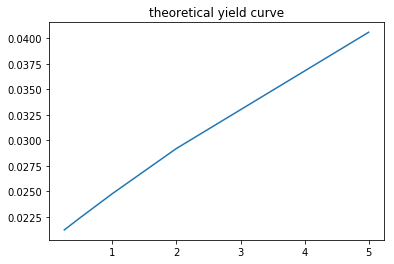

In [5]:
## check the theoretical yield curve
def get_y(time_to_maturity, alpha=0.02):
    a,b = get_coef(time_to_maturity, param_vector)
    return -a + b*alpha

x = [0.25, 0.5, 1, 2, 5]
y = [get_y(t) for t in x]
get_coef(0.25, param_vector)
plt.plot(x, y)
plt.title("theoretical yield curve")

In [6]:
def generate_truncated_normal(mean, std, n, clip=0):
    if not n:
        return None
    result = np.random.normal(mean, std, size=n)
    clipped_index = result<0
    if np.any(clipped_index):
        result[clipped_index] = generate_truncated_normal(mean, std, np.sum(clipped_index), clip=clip)
    return result

In [7]:
a = np.array([0,1,2])
np.cumsum(a)

array([0, 1, 3])

In [8]:
def get_a(coef_B, h=1e-3):
    return np.sum(np.square(coef_B)) / (2 * h)

def get_b_c(observed_y, coef_A, coef_B, h=1e-3):
    return -np.sum((observed_y - coef_A) * coef_B) / h, 1 / (2*h) *np.sum(np.square(observed_y - coef_A))

def phi(x, a, b, c, h, N):
    return 1 / np.power(2 * np.pi * h, N / 2) * np.exp(-a*np.square(x) - b * x - c)

def get_K(a, b, c, h, N):
    result = integrate.quad(lambda x: phi(x, a, b, c, h, N), 0, float("inf"))
    return result[0]

def resample(alpha, w):
    cdf = np.cumsum(w) / np.sum(w)
    cdf_hat = np.ones_like(w) * 1. / len(w)
    cdf_hat[0] = 0
    cdf_hat = np.cumsum(cdf_hat)
    cdf_hat += np.random.uniform(0, 1. / len(w))
    
    result = np.zeros_like(alpha)
    j = 0
    for i in range(len(w)):
        while cdf[j] < cdf_hat[i]:
            j += 1
        result[i] = alpha[j]
    return result

def get_n_tilda(w):
    return np.square(np.sum(w)) / np.sum(np.square(w))

def likelihood_estimate_by_partical_filter(param_vector: np.ndarray, num_particles: int, delta_t: float, \
                                           observed_y_matrix: np.ndarray, time_to_maturity_array: np.ndarray, h):
    """
    observed_y_matrix: T by N matrix
    return the loglikelihood
    """
    T, N = observed_y_matrix.shape
    assert N == time_to_maturity_array.size
    coef_A, coef_B = get_coef(time_to_maturity_array, param_vector)
    log_likelihood = 0
    const_c = get_const_c(param_vector, delta_t)
    const_q = get_const_q(param_vector)
    a = get_a(coef_B, h)
    # initial alpha and w
    b, c = get_b_c(observed_y_matrix[0], coef_A, coef_B, h)
    alpha = generate_truncated_normal(mean=-b/(2*a), std=np.sqrt(1/(2*a)), n=N)
    # alpha_1 follows gamma distribution
    shape_param = const_q+1
    scale_param = 1 / (const_c * (1 - np.exp(-param_vector[0]*delta_t)))
    K = get_K(a, b, c, h, N)
    w = K * gamma.pdf(x=alpha, a=shape_param, scale=scale_param)
    log_likelihood += np.log(np.mean(w))
    for t in range(1, T):
        b, c = get_b_c(observed_y_matrix[t], coef_A, coef_B, h)
        new_alpha = generate_truncated_normal(mean=-b/(2*a), std=np.sqrt(1/(2*a)), n=N)
        # alpha_t conditioning on alpha_{t-1} follows non-central X2 distribution.
        nc = 2 * const_c * np.exp(-param_vector[0]*delta_t) * alpha
        K = get_K(a, b, c, h, N)
        conditional_prob = 2*const_c*ncx2.pdf(2*const_c*new_alpha, 2*const_q+2, nc)
        new_w = K * conditional_prob * w / np.sum(w)
        n_tilda = get_n_tilda(new_w)
        if n_tilda < num_particles / 2.:
            new_alpha = resample(new_alpha, new_w)
            new_w = np.ones_like(new_w) * np.sum(new_w) / num_particles
        log_likelihood += np.log(np.sum(new_w))
        w = new_w
        alpha = new_alpha
    return log_likelihood


In [9]:
def simulate_path(param_vector, delta_t, T, time_to_maturity_array, h=1e-3):
    observed_y = np.ones((T, time_to_maturity_array.size), dtype=np.float64)
    
    const_c = get_const_c(param_vector, delta_t)
    const_q = get_const_q(param_vector)
    alpha = np.random.gamma(shape=const_q+1, scale=1/(const_c * (1 - np.exp(-param_vector[0]*delta_t))))
    coef_A, coef_B = get_coef(time_to_maturity_array, param_vector)
    observed_y[0] = -coef_A + coef_B * alpha + np.random.normal(0, h, size=time_to_maturity_array.size)
    for ii in range(1, T):
        nc = 2 * const_c * np.exp(-param_vector[0]*delta_t) * alpha
        alpha = np.random.noncentral_chisquare(df=2*const_q+2, nonc=nc) / (2 * const_c)
        observed_y[ii] = -coef_A + coef_B * alpha + np.random.normal(0, h, size=time_to_maturity_array.size)
    return observed_y

In [10]:
y_list = []
for i in range(100):
    y_list.append(simulate_path(param_vector, 1./52, 150, np.array([0.25, 1, 3, 5, 10])))

In [11]:
def get_ll(vector):
    result = []
    for y in y_list:
        result.append(likelihood_estimate_by_partical_filter(vector, 200, 1./52, y, np.array([0.25, 1, 3, 5, 10]), 1e-3))
    return np.mean(result)

In [12]:
get_ll(param_vector)

/home/rui/.pyenv/versions/3.6.6/envs/tensor36/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


-2381.2816915100175

In [13]:
get_ll(np.array([0.3, 0.05, 0.0481, -32.03]))

/home/rui/.pyenv/versions/3.6.6/envs/tensor36/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


-2704.468457646054